In [24]:
!pwd
import sys
sys.path.append("..")
from bumps.names import Curve, fit, FitProblem
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import molgroups as mol


/Users/alyssa/molgroups/examples/diffraction/DOPC


some functions

In [25]:
def getSLD(aArea, aSL, dimension, stepsize, normArea, bulksld):
    aSLD = np.zeros(dimension).tolist()
    for i in range(dimension):
        if aArea[i] != 0:
            aSLD[i] = aSL[i] / (aArea[i] * stepsize) * aArea[i] / normArea + bulksld * (
                1 - aArea[i] / normArea
            )
        else:
            aSLD[i] = bulksld
    return aSLD


In [26]:
def computeFormFactor(lq, aSLD, dimension, stepsize, bulksld, prefactor, dq):
    center = bilayer.fnGetCenter()
    center = center // stepsize
    canvas_center = dimension // 2
    n = int(canvas_center - center)
    centered_bilayer = np.roll(aSLD, n)
    symmetrized_bilayer = np.add(centered_bilayer, centered_bilayer[::-1]) * 0.5
    symmetrized_bilayer -= bulksld
    half_bilayer = symmetrized_bilayer[int(dimension / 2) :]

    # TODO: Make sure that lq and x are roughly comparable
    dct_dimension = 5000
    F = fft.dct(half_bilayer, n=dct_dimension)
    F = np.abs(F)
    x = np.array(
        [
            np.pi / (2 * dct_dimension * stepsize) * (2 * i) * dq
            for i in range(dct_dimension)
        ]
    )

    # interpolate (x, F) onto lq -> (lq, modelform)
    return np.interp(lq, x, F, left=None, right=None, period=None) * prefactor


In [27]:
def setBilayer(startz, l_lipid, sigma, bulksld, rel_pos, hg_thickness, methyl_sigma):
    bilayer.headgroups1[0].fnSet(hg_thickness, rel_pos)
    bilayer.headgroups2[0].fnSet(hg_thickness, rel_pos)
    bilayer.methyl_sigma = methyl_sigma
    bilayer.fnSet(sigma, bulksld, startz, l_lipid, l_lipid, vf_bilayer=1)


In [28]:
def modelformfactor(
    lq, l_lipid, sigma, bulksld, prefactor, dq, rel_pos, hg_thickness, methyl_sigma
):
    setBilayer(startz, l_lipid, sigma, bulksld, rel_pos, hg_thickness, methyl_sigma)
    z = np.linspace(0, dimension * stepsize, dimension, endpoint=False)
    normArea, aArea, aSL = bilayer.fnWriteProfile(z)
    aSLD = getSLD(aArea, aSL, dimension, stepsize, normArea, bulksld)
    modelform = computeFormFactor(lq, aSLD, dimension, stepsize, bulksld, prefactor, dq)
    problem.extra = bilayer
    problem.stepsize = stepsize
    problem.dimension = dimension
    problem.sld = aSLD
    return modelform


Global Variables

In [29]:
maxarea = 100
stepsize = 0.5
dimension = 300
startz = 50


Load Experimental Data

In [30]:
ULV = np.loadtxt("exp_data/dopcULV.dat")
MLV = np.loadtxt("exp_data/dopcMLVs.dat")
ORI = np.loadtxt("exp_data/dopcOri.dat")
F2 = np.concatenate((ULV, MLV, ORI))
F2 = F2[np.argsort(F2[:, 0])]
q_exp = F2[:, 0]
form_exp = F2[:, 1]
# constant error bar estimate of .05 Å
dform_exp = [0.05] * len(form_exp)


Set scattering lengths, volumes, lengths
| abb | name |
| :- | :- |
|va1 |Volume acyl chains, lipid 1|
|na1 |SL acyl chains, lipid 1|
|vm1 |Volume methyl groups, lipid 1|
|nm1 |SL methyl groups, lipid 1|
|vh1 |Headgroup volume, lipid 1|
|nh1 |SL headgroup, lipid 1|
|lh1 |Length headgroup, lipid 1|
|va2 |Volume acyl chains, lipid 2|
|na2 |SL acyl chains, lipid 2|
|vm2 |Volume methyl groups, lipid 2|
|nm2 |SL methyl groups, lipid 2|
|vh2 |Headgroup volume, lipid 2|
|nh2 |SL headgroup, lipid 2|
|lh2 |Length headgroup, lipid 2|
|va3 |Volume acyl chains, lipid 3|
|na3 |SL acyl chains, lipid 3|
|vm3 |Volume methyl groups, lipid 3|
|nm3 |SL methyl groups, lipid 3|
|vh3 |Headgroup volume, lipid 3|
|nh3 |SL headgroup, lipid 3|
|lh3 |Length headgroup, lipid 3|
|vc  |volume cholesterol|
|nc  |SL cholesterol|


In [31]:
bilayer = mol.BLM()
# na1, nh1, nm1, va1, vm1, vh1, lh1 = (
#     7.5978e-03,
#     4.6150e-03,
#     5.0652e-04,
#     972.00,
#     98,
#     331.00,
#     9.56,
# )
# bilayer.fnInit(va1, na1, vm1, nm1, vh1, nh1, lh1)


In [32]:
l_lipid = 11.6
sigma = 2.0
bulksld = 9.4114e-06
prefactor = 15000
dq = 1.0
rel_pos = 0.5
methyl_sigma = 2
lh1 = 9.56


In [33]:
M1 = Curve(
    modelformfactor,
    q_exp,
    form_exp,
    dform_exp,
    l_lipid=l_lipid,
    sigma=sigma,
    bulksld=bulksld,
    prefactor=prefactor,
    dq=dq,
    rel_pos=rel_pos,
    hg_thickness=lh1,
    methyl_sigma=methyl_sigma,
)


In [34]:
M1.l_lipid.range(9, 13)
M1.sigma.range(2.0, 4.0)
M1.bulksld.range(9e-6, 10e-6)
M1.prefactor.range(5000, 30000)
M1.dq.range(0.95, 1.05)
M1.hg_thickness.range(8, 12)
M1.rel_pos.range(0, 1)
M1.methyl_sigma.range(0, 4)


Parameter(methyl_sigma)

In [35]:
model = M1
problem = FitProblem(model)


In [60]:
result = fit(
    problem,
    method="dream",
    samples=10,
    burn=10,
    steps=10,
    thin=1,
    alpha=0,
    outliers="none",
    trim="none",
    verbose = True,
)


# steps: 10, # draws: 800
step 1 cost 712.610(16)
                                 bulksld ....|..... 9.40914e-06 in (9e-06,1e-05)
                                      dq ....|.....    0.99934 in (0.95,1.05)
                            hg_thickness ...|......    9.55908 in (8,12)
                                 l_lipid ......|...    11.5969 in (9,13)
                            methyl_sigma ....|.....    1.99554 in (0,4)
                               prefactor ....|.....    15001.3 in (5000,30000)
                                 rel_pos ....|.....   0.499707 in (0,1)
                                   sigma |.........    2.00025 in (2,4)
step 4 cost 712.269(16)
step 7 cost 711.265(16)
step 11 cost 685.754(16)
step 15 cost 625.690(16)
step 19 cost 495.499(16)
Did not converge!
final chisq 419.067(16)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                                 bulksld 9.0(66)e-6      9.00(32)e-6    
                                  

In [61]:
store = 'T2'
if not os.path.isdir(store): 
    os.mkdir(store)

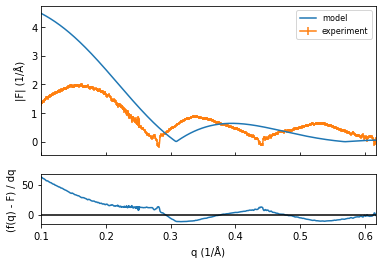

In [62]:
import plot
result.state.save(store + "/run")
problem.fitness.save(store + "/run")
plot.graphBumpsResults(store + "/run.dat")


In [63]:
from bumps.dream.stats import var_stats, format_vars, save_vars

print("final chisq", problem.chisq_str())
draw = result.state.draw(portion=1)
all_vstats = var_stats(draw)
print(format_vars(all_vstats))
save_vars(all_vstats, store + "/run")


final chisq 419.067(16)
              Parameter       mean  median    best [   68% interval] [   95% interval]
 1              bulksld 9.402(44)e-6 0.0000094091 0.0000090011 [0.000009400 0.000009409] [0.000009328 0.000009426]
 2                   dq 0.9958(91)  0.9993  1.0082 [  0.994   0.999] [  0.964   1.000]
 3         hg_thickness  9.563(81)   9.559   9.024 [   9.56    9.57] [   9.51    9.63]
 4              l_lipid  11.48(36)  11.597   9.583 [  11.47   11.60] [  10.35   11.62]
 5         methyl_sigma  1.995(24)  1.9955  1.8127 [  1.994   1.997] [  1.978   2.011]
 6            prefactor 15001.3(31) 15001.26 14985.50 [15000.5 15001.9] [14994.4 15006.4]
 7              rel_pos 0.5002(90)  0.4997  0.5206 [  0.499   0.501] [  0.487   0.514]
 8                sigma   2.03(13)   2.000   3.620 [   2.00    2.02] [   2.00    2.20]


/opt/anaconda3/envs/bumps/lib/python3.8/site-packages/bumps/dream/varplot.py:240: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pylab.pcolormesh(x, y, z, vmin=vmin, vmax=vmax, cmap=cmap)
/opt/anaconda3/envs/bumps/lib/python3.8/site-packages/bumps/dream/varplot.py:244: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centers, height, maxlikelihood = array(bins).T
/opt/anaconda3/envs/bumps/lib/python3.8/site-packages/bumps/dream/varplot.py:248: RuntimeWarning: divide by zero encountered in true_divide
  maxli

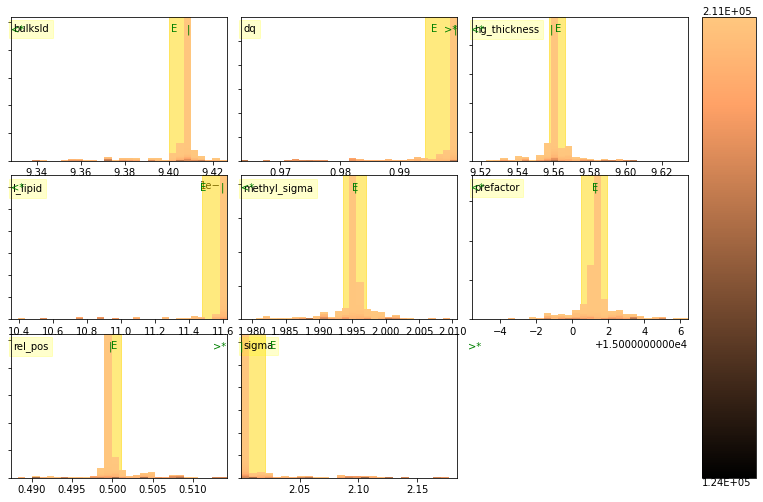

In [64]:
from bumps.dream import corrplot, varplot
from pylab import figure, savefig, suptitle, rcParams

figure(figsize=varplot.var_plot_size(len(all_vstats)))
nbins = max(min(draw.points.shape[0] // 10000, 400), 30)
varplot.plot_vars(draw, all_vstats, nbins=nbins)
savefig(store + "/var")


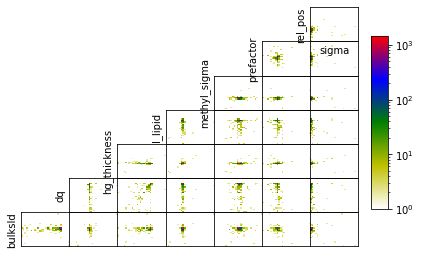

In [65]:
if draw.num_vars <= 25:
    figure()
    c = corrplot.Corr2d(draw.points.T, bins=nbins, labels=draw.labels)
    c.plot()
savefig(store + "/corr")


In [66]:
import plot

bulksld, dq, hg_thickness, l_lipid, methyl_sigma, prefactor, rel_pos, sigma = result.x
setBilayer(startz, l_lipid, sigma, bulksld, rel_pos, hg_thickness, methyl_sigma)
# plot.graphProfiles(
#     bilayer, dimension, stepsize, maxarea, bulksld, show=True, savefile=None
# )


In [67]:
p = result.state.best()[0]
problem.setp(p)
print(problem.chisq())


419.0672387486912


In [68]:
sys.path.append(os.pardir + '/PlottingAndAnalysis') #TODO implement packages?
import rs
import os

setupdir = os.getcwd()
mcmcstor = store
runfile = "run"
fitsource = "bumps"

if os.path.isfile(mcmcstor + "/sErr.dat"):
    os.remove(mcmcstor + "/sErr.dat")
if os.path.isfile(mcmcstor + "/isErr.dat"):
    os.remove(mcmcstor + "/isErr.dat")
if os.path.isfile(mcmcstor + "/StatDataPython.dat"):
    os.remove(mcmcstor + "/StatDataPython.dat")

fit_analysis = rs.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=mcmcstor,
    runfile=runfile,
    state=result.state,
    problem=problem,
)


In [69]:
sparse = 0.002
fit_analysis.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)


Analysis of current MC simulation ...
Number of iterations: 3
     bulksld  [    +      ]  [     9e-06,     1e-05]  [ 9.407e-06(0.000),  9.409e-06(0.000),  9.411e-06(0.000)] (- 1.983e-09, + 1.529e-09)
          dq  [   | +     ]  [      0.95,      1.05]  [    0.9804(0.000),     0.9982(0.000),     0.9986(0.000)] (-   0.01784, +  0.000383)
hg_thickness  [    +      ]  [         8,        12]  [     9.538(0.000),      9.561(0.000),      9.566(0.000)] (-   0.02276, +  0.005193)
     l_lipid  [     |+    ]  [         9,        13]  [     11.16(0.000),       11.6(0.000),       11.6(0.000)] (-    0.4375, + 0.0009702)
methyl_sigma  [     +     ]  [         0,         4]  [     1.995(0.000),      1.995(0.000),      1.998(0.000)] (- 0.0006997, +  0.002094)
   prefactor  [    +      ]  [      5000,     3e+04]  [   1.5e+04(0.000),    1.5e+04(0.000),    1.5e+04(0.000)] (-     3.707, +    0.6911)
     rel_pos  [     +     ]  [         0,         1]  [    0.4997(0.000),     0.4999(0.000),     0.5036(

In [70]:
fit_analysis.fnPullMolgroup(["lipid1"], sparse=sparse)


Failure to load StatDataPython.dat.
Recreate statistical data from sErr.dat.
Found sErr.dat

Processing parameter set 0.

710.5660460321639
Processing parameter set 1.

643.613790335895
Processing parameter set 2.

709.2773468146361
Molecular group lipid1 does not exist.


In [71]:
fit_analysis.fnCreateBilayerPlotData()


Initializing ...
Pulling all molgroups ...
  substrate ...
Loaded statistical data from StatDataPython.dat
Molecular group bilayer_substrate does not exist.
  siox ...
Loaded statistical data from StatDataPython.dat
Molecular group bilayer_siox does not exist.
  tether ...
Loaded statistical data from StatDataPython.dat
Molecular group bilayer_bME does not exist.
Molecular group bilayer_tetherg does not exist.
Molecular group bilayer_tether does not exist.
  innerhg ...
Loaded statistical data from StatDataPython.dat
Molecular group bilayer_headgroup1 does not exist.
Molecular group bilayer_headgroup1_2 does not exist.
Molecular group bilayer_headgroup1_3 does not exist.
Loaded statistical data from StatDataPython.dat
Molecular group bilayer_headgroup1_cg does not exist.
Loaded statistical data from StatDataPython.dat
Molecular group bilayer_headgroup1_phosphate does not exist.
Loaded statistical data from StatDataPython.dat
Molecular group bilayer_headgroup1_choline does not exist.
  

In [72]:
fit_analysis.fnCalculateMolgroupProperty(fConfidence=-1)


Loaded statistical data from StatDataPython.dat
Did not find any fractional envelopes ...
bilayer_defect_hc_AVG  [         0,          0,          0] (-         0, +         0)
bilayer_defect_hc_COM  [     1e+05,      1e+05,      1e+05] (-         0, +         0)
bilayer_defect_hc_INT  [         0,          0,          0] (-         0, +         0)
bilayer_defect_hg_AVG  [         0,          0,          0] (-         0, +         0)
bilayer_defect_hg_COM  [     1e+05,      1e+05,      1e+05] (-         0, +         0)
bilayer_defect_hg_INT  [         0,          0,          0] (-         0, +         0)
bilayer_headgroup1_1_AVG  [      2.14,       2.14,       2.14] (- 2.277e-08, + 7.478e-08)
bilayer_headgroup1_1_COM  [     55.39,       55.4,      55.41] (-   0.01581, +  0.003072)
bilayer_headgroup1_1_INT  [     4.102,      4.263,      4.263] (-    0.1608, +  0.000357)
bilayer_headgroup1_1_cg_AVG  [      0.98,       0.98,       0.98] (- 8.749e-09, + 1.618e-08)
bilayer_headgroup1_1_cg_C

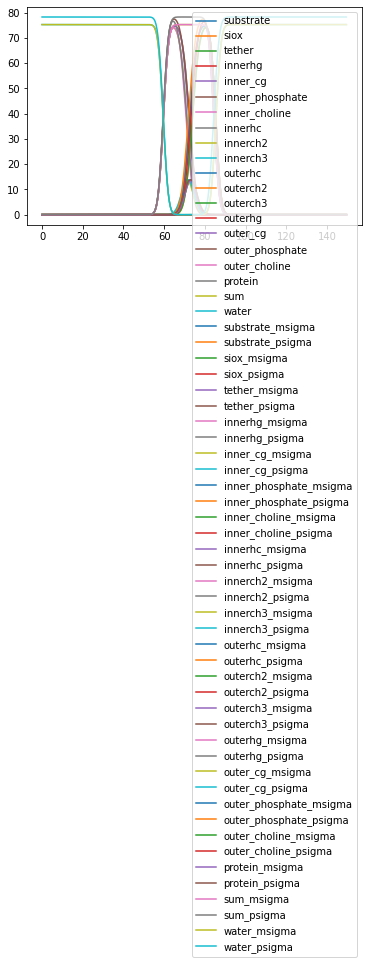

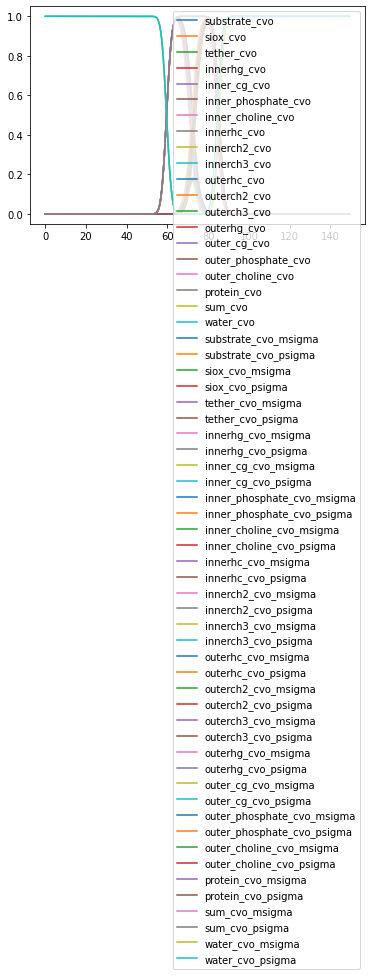

In [73]:
import pandas as pd
import matplotlib.pyplot as plt

bilayer_plot_data = pd.read_csv(store +"/bilayerplotdata.dat", sep="\s", engine="python")
area = []
cvo = []
for elem in bilayer_plot_data.keys():
    if "corr" in elem or "zaxis" in elem:
        continue
    if "cvo" in elem:
        cvo.append(elem)
        continue
    area.append(elem)

for i, elem in enumerate(area):
    plt.plot(bilayer_plot_data["zaxis"], bilayer_plot_data[elem], label=elem)
plt.legend()
plt.show()
for i, elem in enumerate(cvo):
    plt.plot(bilayer_plot_data["zaxis"], bilayer_plot_data[elem], label=elem)
plt.legend()
plt.show()
